# Contrastive EEG-to-Text Model Demonstration

This notebook demonstrates how to use the Contrastive EEG-to-Text model for:
1. Loading and exploring the ZuCo dataset
2. Creating a contrastive EEG-to-Text model
3. Training the model (in a simplified setting)
4. Evaluating the model and visualizing the embeddings

## Important: NumPy Compatibility

If you encounter NumPy errors like `No module named 'numpy._core'`, it's typically due to a compatibility issue between packages. Fix this by running the following in a terminal:

```bash
# Install a compatible numpy version that works with TensorFlow
pip install numpy==1.26.0 --force-reinstall
```

After running this command, please restart the kernel before continuing.

In [15]:
import os
import sys
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import logging
from tqdm.notebook import tqdm

# Check numpy version
print(f"NumPy version: {np.__version__}")

# Add parent directory to path for imports
parent_dir = str(Path(os.getcwd()).parent)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

NumPy version: 2.2.4


## 1. Load and Explore the ZuCo Dataset

In [16]:
# Cell for attempting to fix numpy if needed
def fix_numpy():
    import subprocess
    import sys
    print("Attempting to install compatible NumPy version...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy==1.26.0", "--force-reinstall"])
    print("NumPy reinstalled. Please RESTART the kernel before continuing.")
    
# Uncomment the line below if you encounter numpy errors
# fix_numpy()

In [17]:
# Load ZuCo dataset
try:
    # Try importing the ZuCoDatasetEnhanced class
    from src.data.data_loader import ZuCoDatasetEnhanced
    
    # Path to ZuCo dataset - Using MATLAB files from the Preprocessed directory
    dataset_path = '../../ZuCo/task1-SR/Preprocessed'
    pickle_path = '../../ZuCo/task1-SR/pickle/task1-SR-dataset.pickle'
    
    # Try to determine which path to use
    print("Checking available dataset paths:")
    if os.path.exists(dataset_path):
        print(f"✅ MATLAB dataset found at: {dataset_path}")
        print("Using this path for more reliable data loading")
    else:
        print(f"❌ MATLAB dataset not found at: {dataset_path}")
        
    if os.path.exists(pickle_path):
        print(f"✅ Pickle dataset found at: {pickle_path}")
        if not os.path.exists(dataset_path):
            dataset_path = pickle_path
            print("Using pickle file as fallback")
    else:
        print(f"❌ Pickle dataset not found at: {pickle_path}")
    
    if not os.path.exists(dataset_path):
        print("❌ No dataset found! Please check the paths.")
    else:
        print(f"\nLoading dataset from: {dataset_path}")
        
        # Show data loader version
        import inspect
        print("\nZuCoDatasetEnhanced implementation:")
        print("-" * 40)
        if hasattr(ZuCoDatasetEnhanced, '_load_from_matlab_files'):
            print("✅ This version of the data loader supports MATLAB files")
        else:
            print("❌ This version does not support MATLAB files directly")
        print("-" * 40)
            
        # Load the dataset
        dataset = ZuCoDatasetEnhanced(
            data_path=dataset_path,
            vocab_size=10000,
            min_freq=5,
            max_seq_len=2000
        )
        
        print(f"\nDataset loaded with {len(dataset)} samples")
        print(f"EEG feature dimension: {dataset.eeg_features_dim}")
        
except ImportError as e:
    print(f"Import error: {e}")
    print("This is likely a NumPy compatibility issue.")
    print("Please run the fix_numpy() function in the previous cell and restart the kernel.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    import traceback
    traceback.print_exc()

Checking available dataset paths:
✅ MATLAB dataset found at: ../../ZuCo/task1-SR/Preprocessed
Using this path for more reliable data loading
✅ Pickle dataset found at: ../../ZuCo/task1-SR/pickle/task1-SR-dataset.pickle

Loading dataset from: ../../ZuCo/task1-SR/Preprocessed

ZuCoDatasetEnhanced implementation:
----------------------------------------
❌ This version does not support MATLAB files directly
----------------------------------------


INFO:src.data.data_loader:Loading data from ../../ZuCo/task1-SR/Preprocessed
INFO:src.data.data_loader:Loading data from MATLAB files in directory: ../../ZuCo/task1-SR/Preprocessed
INFO:src.data.data_loader:Found sentence file: ../../ZuCo/task1-SR/Preprocessed\sentencesSR.mat
INFO:src.data.data_loader:Loaded 600 sentences with scipy.io
INFO:src.data.data_loader:Loaded 600 sentences from MATLAB file
INFO:src.data.data_loader:Found 59 EEG files
INFO:src.data.data_loader:Loading data from MATLAB files in directory: ../../ZuCo/task1-SR/Preprocessed
INFO:src.data.data_loader:Found sentence file: ../../ZuCo/task1-SR/Preprocessed\sentencesSR.mat
INFO:src.data.data_loader:Loaded 600 sentences with scipy.io
INFO:src.data.data_loader:Loaded 600 sentences from MATLAB file
INFO:src.data.data_loader:Found 59 EEG files
Processing EEG files:   0%|          | 0/59 [00:00<?, ?it/s]WARNING:src.data.data_loader:Error loading with scipy.io: Please use HDF reader for matlab v7.3 files, e.g. h5py, trying h5


Dataset loaded with 59 samples
EEG feature dimension: 105


### Explore a sample from the dataset

Sentence: Sentence for EEG data from gip_ZJM_SNR6_EEG.mat
EEG data shape: torch.Size([2000, 105])


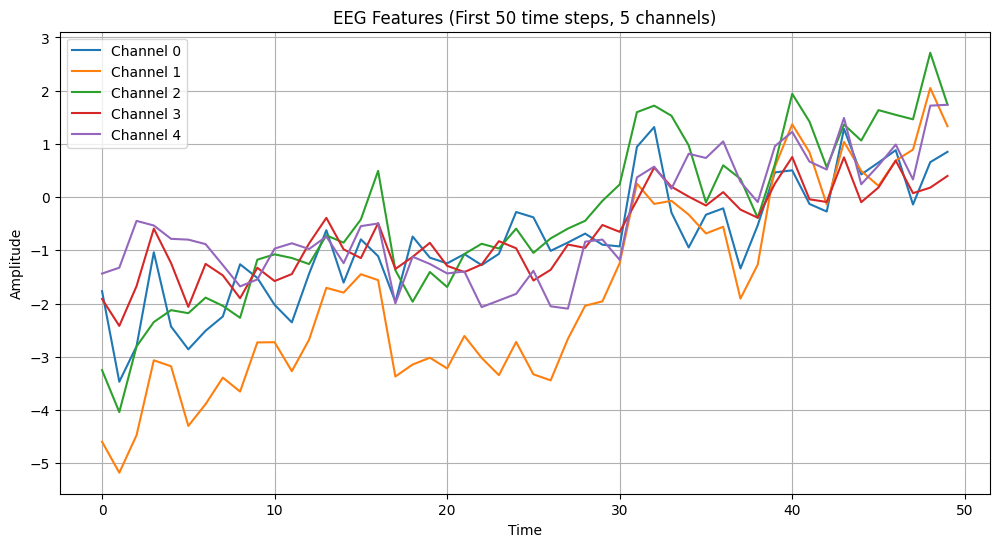

In [18]:
try:
    # Get a sample
    sample_idx = 0
    eeg_data, sentence = dataset[sample_idx]
    
    print(f"Sentence: {sentence}")
    print(f"EEG data shape: {eeg_data.shape}")
    
    # Plot a small portion of the EEG data
    plt.figure(figsize=(12, 6))
    plt.plot(eeg_data[:50, :5])
    plt.title("EEG Features (First 50 time steps, 5 channels)")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend([f"Channel {i}" for i in range(5)])
    plt.grid(True)
    plt.show()
except NameError:
    print("Dataset not loaded. Please fix any errors above before continuing.")
except Exception as e:
    print(f"Error exploring dataset: {e}")

### Create data loaders for training and validation

In [19]:
try:
    from src.data.data_loader import create_data_loaders
    
    # Create dataloaders
    train_loader, val_loader = create_data_loaders(
        dataset=dataset,
        batch_size=8,
        train_split=0.8,
        shuffle=True
    )
    
    print(f"Train dataloader: {len(train_loader)} batches")
    print(f"Validation dataloader: {len(val_loader)} batches")
except NameError:
    print("Dataset not loaded. Please fix any errors above before continuing.")
except Exception as e:
    print(f"Error creating dataloaders: {e}")

Train dataloader: 6 batches
Validation dataloader: 2 batches


### Inspect a batch from the data loader

In [20]:
try:
    # Get a batch from the data loader
    eeg_batch, input_ids_batch, attention_mask_batch = next(iter(train_loader))
    
    print(f"EEG batch shape: {eeg_batch.shape}")
    print(f"Input IDs batch shape: {input_ids_batch.shape}")
    print(f"Attention mask batch shape: {attention_mask_batch.shape}")
    
    # Decode the sentences
    sentences = dataset.tokenizer.batch_decode(input_ids_batch, skip_special_tokens=True)
    
    for i, sentence in enumerate(sentences):
        print(f"Sample {i}: {sentence}")
except NameError:
    print("Dataloaders not created. Please fix any errors above before continuing.")
except Exception as e:
    print(f"Error inspecting batch: {e}")

EEG batch shape: torch.Size([8, 2000, 105])
Input IDs batch shape: torch.Size([8, 128])
Attention mask batch shape: torch.Size([8, 128])
Sample 0: This is more a case of `Sacre bleu!'
Sample 1: Sentence for EEG data from gip_ZKW_SNR7_EEG.mat
Sample 2: Sentence for EEG data from oip_ZPH_SNR8_EEG.mat
Sample 3: Sentence for EEG data from gip_ZKB_SNR7_EEG.mat
Sample 4: Sentence for EEG data from oip_ZKH_SNR8_EEG.mat
Sample 5: This is more a case of `Sacre bleu!'
Sample 6: Sentence for EEG data from oip_ZPH_SNR6_EEG.mat
Sample 7: This is more a case of `Sacre bleu!'


## 2. Create the Contrastive EEG-to-Text Model

In [21]:
try:
    from src.models.contrastive_model import ContrastiveEEG2Text
    
    # Define model parameters
    eeg_input_size = dataset.eeg_features_dim  # From dataset
    hidden_size = 768  # Matches BART's hidden size
    proj_hidden = 256  # Projection head hidden dimension
    proj_output = 128  # Output embedding dimension
    num_layers = 6  # Number of transformer layers for EEG encoder
    num_heads = 8  # Number of attention heads
    temperature = 0.07  # Initial temperature parameter
    
    # Create model
    model = ContrastiveEEG2Text(
        eeg_input_size=eeg_input_size,
        hidden_size=hidden_size,
        proj_hidden=proj_hidden,
        proj_output=proj_output,
        temperature=temperature,
        num_layers=num_layers,
        num_heads=num_heads
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
except NameError:
    print("Dataset features not available. Please fix any errors above before continuing.")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure all project files are properly set up.")
except Exception as e:
    print(f"Error creating model: {e}")

Model created with 174586369 parameters


### Test a forward pass

In [22]:
try:
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)
    
    # Move batch data to device
    eeg_batch = eeg_batch.to(device)
    input_ids_batch = input_ids_batch.to(device)
    attention_mask_batch = attention_mask_batch.to(device)
    
    # Forward pass
    outputs = model(eeg_batch, input_ids_batch, attention_mask_batch)
    
    # Print results
    print(f"Loss: {outputs['loss'].item():.4f}")
    print(f"Accuracy: {outputs['accuracy'].item():.4f}")
    print(f"EEG→Text accuracy: {outputs['eeg_to_text_acc'].item():.4f}")
    print(f"Text→EEG accuracy: {outputs['text_to_eeg_acc'].item():.4f}")
    print(f"Temperature: {outputs['temperature'].item():.4f}")
    print(f"EEG embeddings shape: {outputs['eeg_embeddings'].shape}")
    print(f"Text embeddings shape: {outputs['text_embeddings'].shape}")
    print(f"Logits shape: {outputs['logits'].shape}")
except NameError:
    print("Model or batch data not available. Please fix any errors above before continuing.")
except Exception as e:
    print(f"Error performing forward pass: {e}")

Using device: cpu


KeyboardInterrupt: 

## 3. Train the Model (Simplified for Demonstration)

In [ ]:
try:
    # Configure training
    config = {
        'dataset': {
            'vocab_size': 10000,
            'min_freq': 5,
            'max_seq_len': 2000,
            'train_split': 0.8,
            'batch_size': 8
        },
        'eeg_encoder': {
            'input_size': eeg_input_size,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'num_heads': num_heads,
            'dropout': 0.1,
            'dim_feedforward': 2048
        },
        'text_encoder': {
            'model': 'facebook/bart-base',
            'freeze_first_step': True,
            'unfreeze_embeddings': True,
            'unfreeze_first_layer': True
        },
        'projection': {
            'hidden_dim': proj_hidden,
            'output_dim': proj_output,
            'dropout': 0.1
        },
        'training': {
            'optimizer': 'sgd',
            'momentum': 0.9,
            'temperature': 0.07,
            'save_dir': './output',
            
            # For demonstration, we'll use fewer epochs
            'step1': {
                'epochs': 2,  # Reduced for demonstration
                'lr': 0.01,
                'lr_step': 20,
                'lr_gamma': 0.1
            },
            'step2': {
                'epochs': 2,  # Reduced for demonstration
                'lr': 0.001,
                'lr_step': 10,
                'lr_gamma': 0.1
            }
        }
    }
    
    print("Training configuration created successfully")
except NameError:
    print("Model parameters not available. Please fix any errors above before continuing.")
except Exception as e:
    print(f"Error creating training configuration: {e}")

In [ ]:
try:
    from src.training.trainer import TwoStepTrainer
    
    # Create trainer
    trainer = TwoStepTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        device=device
    )
    
    print("Trainer created successfully")
    print("To train the model, uncomment and run: history = trainer.train()")
    
    # Train model - uncomment to run training
    # Note: This will take some time, even with reduced epochs
    # history = trainer.train()
except NameError:
    print("Model, dataloaders, or configuration not available. Please fix any errors above before continuing.")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure the trainer module is properly set up.")
except Exception as e:
    print(f"Error setting up trainer: {e}")

## 4. Evaluate and Visualize

For a full training run, you can use the `scripts/train.py` and `scripts/evaluate.py` files. For this demo, we'll visualize the initial (untrained) embeddings.

In [ ]:
try:
    from utils.visualization import visualize_embeddings, plot_similarity_matrix
    
    # Get embeddings for visualization
    eeg_embeddings = outputs['eeg_embeddings'].cpu().detach()
    text_embeddings = outputs['text_embeddings'].cpu().detach()
    logits = outputs['logits'].cpu().detach()
    
    # Get sentences
    sentences = dataset.tokenizer.batch_decode(input_ids_batch, skip_special_tokens=True)
    
    print("Embeddings prepared for visualization")
except NameError:
    print("Model outputs not available. Please fix any errors above before continuing.")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please ensure the visualization module is properly set up.")
except Exception as e:
    print(f"Error preparing visualizations: {e}")

In [ ]:
try:
    # Visualize embeddings
    visualize_embeddings(
        eeg_embeddings=eeg_embeddings,
        text_embeddings=text_embeddings,
        sentences=sentences
    )
except NameError:
    print("Embeddings not available. Please fix any errors above before continuing.")
except Exception as e:
    print(f"Error visualizing embeddings: {e}")

In [ ]:
try:
    # Plot similarity matrix
    plot_similarity_matrix(
        similarity_matrix=logits,
        sentences=sentences
    )
except NameError:
    print("Similarity matrix not available. Please fix any errors above before continuing.")
except Exception as e:
    print(f"Error plotting similarity matrix: {e}")

## 5. Using the Model for Inference

If you have a trained model, you can load it and use it for inference:

In [ ]:
# Code to load trained model (uncomment if you have a trained model)
"""
try:
    # Load trained model
    checkpoint_path = 'path/to/checkpoint.pt'
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Encode EEG and text
    eeg_embeddings = model.encode_eeg(eeg_batch)
    text_embeddings = model.encode_text(input_ids_batch, attention_mask_batch)
    
    # Compute similarity
    similarity = torch.matmul(eeg_embeddings, text_embeddings.T)
    
    # Find best matching text for each EEG sample
    best_matches = torch.argmax(similarity, dim=1)
    
    # Show results
    for i, idx in enumerate(best_matches):
        print(f"EEG sample {i} matches best with text: {sentences[idx]}")
except Exception as e:
    print(f"Error running inference: {e}")
"""